In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import librosa
from tqdm import tqdm
from IPython.display import Audio
from pandas.api.types import is_numeric_dtype

import sys
sys.path.append('../')
import default_style

TS_DATASET_FOLDER = os.path.join("..", "dataset")
TS_PREPROC_FOLDER = os.path.join(TS_DATASET_FOLDER, "preprocessed_traces")
DF_PREPROC_FILE = os.path.join(TS_PREPROC_FOLDER, "preproc_ts.df")

INTERESTING_TRACES = [ "std_phon_trace", "clean_trace"]


df = pd.read_csv(DF_PREPROC_FILE)
traces = dict()
for t in INTERESTING_TRACES:
    traces[t] = np.load(os.path.join(TS_PREPROC_FOLDER, f"{t}.npy"), allow_pickle=True)

# traces["syll_labels"] = np.repeat(np.arange(7), len(traces["syllables_fourier"])//7)
# print(traces["syll_labels"].shape)

SAMPLING_RATE = 48_000/8

%load_ext autoreload
%autoreload 2

## Short-time Fourier transform

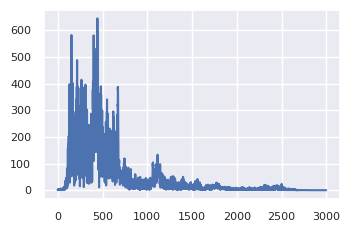

In [3]:
from scipy.fft import fft, ifft, fftfreq

signal = traces["clean_trace"][6]
signal = signal[~np.isnan(signal)]

N, T = len(signal), 1.0/SAMPLING_RATE

spectrum = np.abs(fft(signal)[:N//2])
freqs = fftfreq(N, T)[:N//2]

plt.plot(freqs, spectrum)

Audio split in 50 windows
Each window is 48.50 millisec long
Max frequency is 3.0 kHz


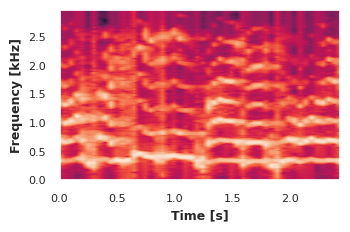

In [4]:
track_index = 1500
signal = traces["clean_trace"][track_index]
signal = signal[~np.isnan(signal)]

M, N, T = 50, len(signal), 1.0/SAMPLING_RATE

windows = np.array_split(signal, M)
winlen = np.min([len(w) for w in windows])

print(f"Audio split in {len(windows)} windows")
print(f"Each window is {winlen/SAMPLING_RATE*1e3:.2f} millisec long")
print(f"Max frequency is {np.max(freqs)*1e-3:.1f} kHz")

STFT = np.zeros((winlen//2, M))

for i, part in enumerate(windows):
    regularized_window = np.hamming(len(part))*part
    window_spectrum = np.abs(fft(regularized_window)[:winlen//2])**2
    STFT[:winlen//2, i] = np.log(window_spectrum/np.sum(window_spectrum))
    
TT, FF = np.linspace(0, N/SAMPLING_RATE, M), fftfreq(winlen, T)[:winlen//2]*1e-3

TT, FF = np.meshgrid(TT, FF)    
plt.contourf(TT.T, FF.T, STFT.T, levels=100)

plt.grid(ls="")
# plt.axis("off")
plt.xlabel("Time [s]");
plt.ylabel("Frequency [kHz]");
# plt.title(f"{df.sex[track_index]} {df.vocal_channel[track_index]} STFT");

## Spectral statistics timeseries

Since the stft returns a matrix (bad), It is possible to extract a statictical feature from the spectrum of each window, such as the spectral centroid

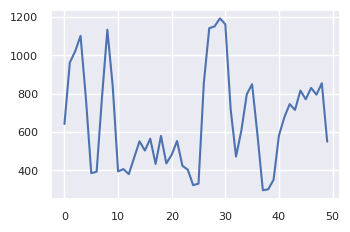

In [5]:
stft_centroid = np.zeros(M)
TT, FF = np.linspace(0, N/SAMPLING_RATE, M), fftfreq(winlen, T)[:winlen//2]

for i in range(M):
    # get a distribution from STFT
    energy_density = np.exp(STFT[:, i]) - np.min(np.exp(STFT[:, i])) # offsets the minimum to be zero
    energy_density /= np.sum(energy_density)         # normalizes
#     plt.plot(FF, energy_density)

    # gets weighted mean
    stft_centroid[i] = np.sum(FF*energy_density)
    
plt.plot(stft_centroid)

## For the full dataset

Since the tracks have different length, the fourier coefficients have different length.
What is possible to do is to bin the spectrum in a range of freqs and then sum the squares (mean energy).

635


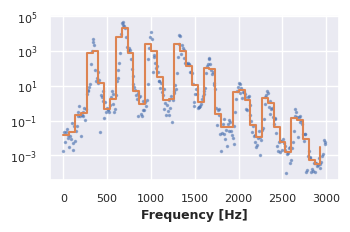

In [27]:
def bin_spectral_energy(spectrum_energy, n_bins, max_freq, sampling_rate=SAMPLING_RATE, plot_check=False):
    if len(spectrum_energy) < n_bins:
        raise ValueError(f"too few frequencies to bin (spectrum has {len(spectrum_energy)})")
    
    T = 1.0/sampling_rate
    
    # Removes higher-pitch part that makes bins unequal
    ss = spectrum_energy[:len(spectrum_energy) - (len(spectrum_energy)%n_bins) ]
    ffs = fftfreq(2*len(ss), T)[:len(ss)]

    ff_bin_edges = np.linspace(0, max_freq, n_bins + 1, endpoint=True)
    
    binned_energies = np.zeros(n_bins)
    for i in range(n_bins):
        binned_energies[i] = np.mean(ss[(ffs >= ff_bin_edges[i])&(ffs < ff_bin_edges[i+1])] )
    
    if plot_check:
        plt.plot(ffs, ss, ls="", marker=".", ms=3,alpha=0.5, label=f"trace length = {2*len(ss)}")
        plt.step(ff_bin_edges[:-1],binned_energies, where="post")
        plt.yscale("log")
        plt.xlabel("Frequency [Hz]")
    return binned_energies

# Test track
test_track_index = 1500
signal = traces["clean_trace"][test_track_index]
signal = signal[~np.isnan(signal)]

part = np.array_split(signal, 23)[0]
regularized_window = np.hamming(len(part))*part
window_spectrum = np.abs(fft(regularized_window)[:len(part)//2])**2
print(len(part))
u = np.log(bin_spectral_energy(window_spectrum, 45, 3000, plot_check=True))

# Comparison
# test_track_index = 1800
# signal = traces["clean_trace"][test_track_index]
# signal = signal[~np.isnan(signal)]

# part = np.array_split(signal, 23)[0]
# regularized_window = np.hamming(len(part))*part
# window_spectrum = np.abs(fft(regularized_window)[:len(part)//2])**2
# print(len(part))
# u = np.log(bin_spectral_energy(window_spectrum, 45, 3000, plot_check=True))

# plt.gcf().legend()
plt.savefig("../images/fourier_binning.pdf")

In [43]:
traces["spectral_centroid"] = []
traces["spectral_mode"] = []
traces["full_stft"] = []

N_SPECTRAL_BINS = 45 
N_TIME_BINS = 60

max_frequencies_taken = np.zeros(len(df))
max_frequencies = max_frequencies_taken.copy()
len_of_windows = max_frequencies.copy()

for tr_indx, tr in tqdm(enumerate(traces["clean_trace"]), total=len(df)):
    
    # Removes padding
    signal = tr[~np.isnan(tr)]
    
    # Gets values of stuff
    N, T = len(signal), 1.0/SAMPLING_RATE

    windows = np.array_split(signal, N_TIME_BINS)
    winlen = np.min([len(w) for w in windows])
    
#     print("signal", len(signal))
#     print("winlen", winlen)
#     print("n of freqs", winlen//2)
    
    STFT = np.zeros((N_TIME_BINS, N_SPECTRAL_BINS))
    STFT_CENTROID = np.zeros(N_TIME_BINS)
    STFT_MODE = np.zeros(N_TIME_BINS)
    FF = fftfreq(winlen, T)[:winlen//2]

    for i, part in enumerate(windows):
        regularized_window = np.hamming(len(part))*part
        window_spectrum = np.abs(fft(regularized_window)[:winlen//2])**2
        
        # Saves the binned STFT
        STFT[i, :] = np.log(bin_spectral_energy(window_spectrum, N_SPECTRAL_BINS, 3000))
        
        # Gets distribution
        energy_density = window_spectrum /np.sum(window_spectrum)
        
        # Gets weighted mean
        STFT_CENTROID[i] = np.sum(energy_density*FF)
        
        # Gets argmax (i.e. the mode)
        STFT_MODE[i] = FF[np.argmax(energy_density)]

    traces["spectral_centroid"].append(STFT_CENTROID)
    traces["spectral_mode"].append(STFT_MODE)
    traces["full_stft"].append(STFT)
    
    # Saves max freqs taken
    max_frequencies[tr_indx] = (FF[-1])
    max_frequencies_taken[tr_indx] = (FF[N_SPECTRAL_BINS])
    len_of_windows[tr_indx] = winlen
    
# Makes them array
traces["spectral_centroid"] = np.array(traces["spectral_centroid"])
traces["spectral_mode"] = np.array(traces["spectral_mode"])
traces["full_stft"] = np.array(traces["full_stft"])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2452/2452 [03:05<00:00, 13.21it/s]


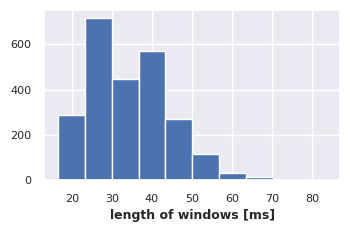

In [45]:
plt.hist(len_of_windows/SAMPLING_RATE*1e3);
plt.xlabel("length of windows [ms]");

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/IPython/core/events.py:93: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


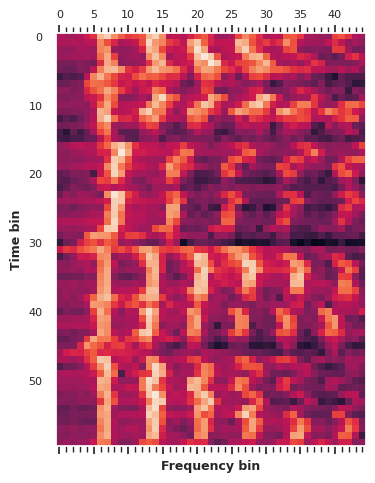

In [46]:
one_curve = traces["full_stft"][1500]
plt.matshow(one_curve)
plt.grid(ls="")
plt.ylabel("Time bin")
plt.xlabel("Frequency bin");

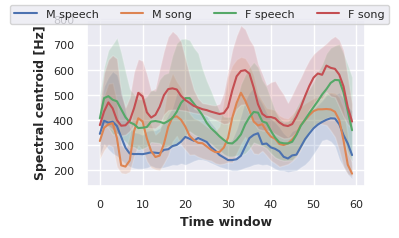

In [47]:
fig, ax = plt.subplots()
for s in ["M", "F"]:
    for vc in ["speech","song"]:
        subsamp = traces["spectral_centroid"][(df.vocal_channel == vc)&(df.sex==s)]
        low, mid, upp = np.quantile(subsamp, [.25, .5, .75], axis=0)
        
        plt.plot(mid, label=f"{s} {vc}")
        plt.fill_between(range(N_TIME_BINS), low, upp,alpha=0.2)
fig.legend(ncols = 4, loc="upper center")
plt.ylabel("Spectral centroid [Hz]")
plt.xlabel("Time window");
fig.tight_layout()

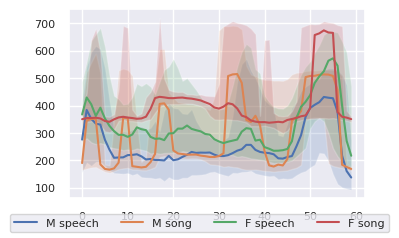

In [48]:
fig, ax = plt.subplots()
for s in ["M", "F"]:
    for vc in ["speech","song"]:
        subsamp = traces["spectral_mode"][(df.vocal_channel == vc)&(df.sex==s)]
        low, mid, upp = np.quantile(subsamp, [.25, .5, .75], axis=0)
        
        plt.plot(mid, label=f"{s} {vc}")
        plt.fill_between(range(N_TIME_BINS), low, upp,alpha=0.2)
fig.legend(ncols = 4, loc="lower center")

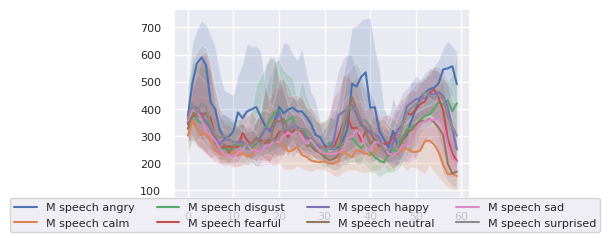

In [49]:
fig, ax = plt.subplots()
for s in ["M"]:
    for vc in ["speech"]:
        for emo in np.unique(df[(df.sex==s)&(df.vocal_channel == vc)].emotion):
        
            subsamp = traces["spectral_centroid"][(df.vocal_channel == vc)&(df.sex==s)&(df.emotion==emo)]
            low, mid, upp = np.quantile(subsamp, [.25, .5, .75], axis=0)

            plt.plot(mid, label=f"{s} {vc} {emo}")
            plt.fill_between(range(N_TIME_BINS), low, upp,alpha=0.2)
fig.legend(ncols = 4, loc="lower center")

In [50]:
for t in ["spectral_centroid", "spectral_mode", "full_stft"]:
    np.save(os.path.join(TS_PREPROC_FOLDER, f"{t}.npy"), traces[t])

## Check umap on spectral centroids

In [51]:
from umap import UMAP

In [52]:
X = traces["spectral_centroid"]

reducer = UMAP(n_neighbors=10)
embedding = reducer.fit_transform(X)

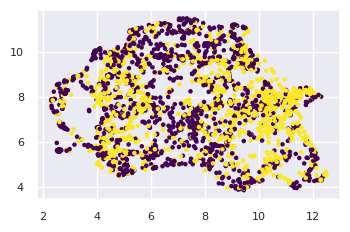

In [53]:
plt.scatter(*embedding.T, s=5, c=(df.emotion=="calm")|(df.emotion=="sad")|(df.emotion=="fearful"), cmap="viridis")

## Test to see the evolution in fourier space

In [54]:
reducer = UMAP(n_neighbors=5)
embedding= reducer.fit_transform(one_curve)

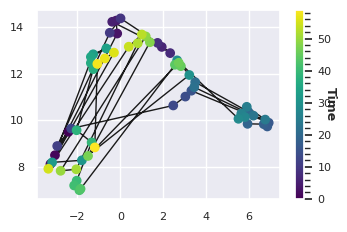

In [55]:
plt.plot(*embedding.T, color="k", lw=1)
plt.scatter(*embedding.T, c=range(N_TIME_BINS), zorder=2, cmap="viridis")
cbar = plt.colorbar()
cbar.ax.set_ylabel('Time', rotation=270);

In [56]:
print("full_stft shape",  traces["full_stft"].shape)
X = traces["full_stft"]

# Merges all tracks together
# In this way UMAP learns the manifold of spectral vectors
# independently from the track
X = X.reshape(-1,N_SPECTRAL_BINS)

print(X.shape)

full_stft shape (2452, 60, 45)
(147120, 45)


In [57]:
reducer = UMAP(n_neighbors=10)

N_SUBSAMP = 10_000
shuffled_subsamp = np.arange(len(X))
np.random.shuffle(shuffled_subsamp)
shuffled_subsamp = shuffled_subsamp[:N_SUBSAMP]

all_spectral_coeff = reducer.fit_transform(X[shuffled_subsamp])

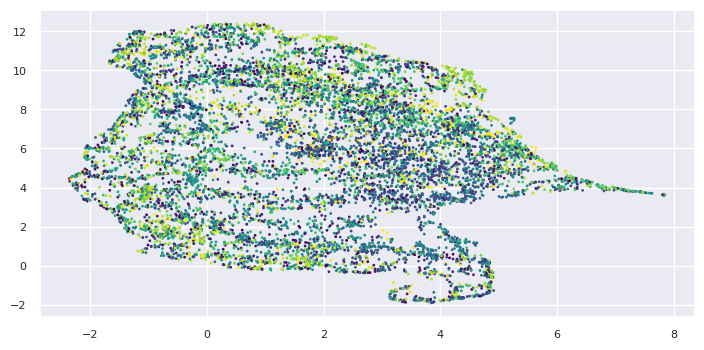

In [58]:
fig, ax =plt.subplots(figsize=default_style.FULLSIZE_FIGURE)
# colors = np.repeat(df.statement == "kids", N_TIME_BINS).values[shuffled_subsamp]
colors = np.tile(range(N_TIME_BINS), len(df))[shuffled_subsamp]
plt.scatter(*all_spectral_coeff.T, s=1, alpha=1, c= colors, cmap="viridis")

In [59]:
from sklearn.manifold import Isomap
reducer = Isomap(n_neighbors=10)

all_spectral_coeff = reducer.fit_transform(X[shuffled_subsamp])

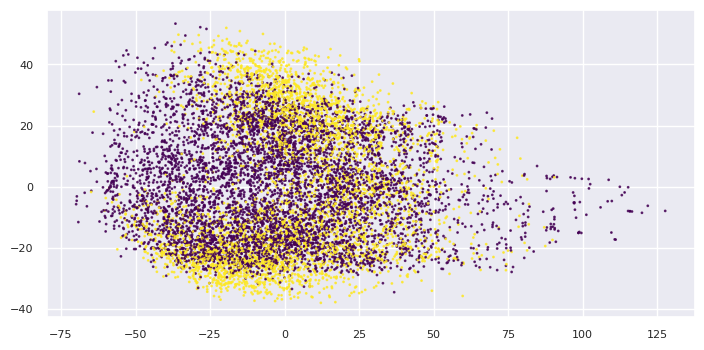

In [60]:
fig, ax =plt.subplots(figsize=default_style.FULLSIZE_FIGURE)
colors = np.repeat(df.vocal_channel == "song", N_TIME_BINS).values[shuffled_subsamp]
plt.scatter(*all_spectral_coeff.T, s=1, alpha=0.8, c= colors, cmap="viridis")

In [61]:
# Now returns to treat each track as a timeseries of points in spectral space
X = X.reshape(-1, N_TIME_BINS, N_SPECTRAL_BINS)

# Predicts the path in 2D that corresponds to a trace
embedding = reducer.transform(X[1500])

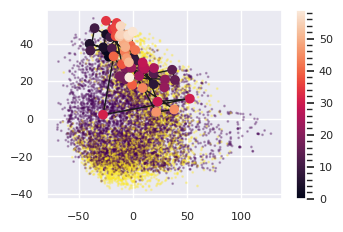

In [62]:
plt.plot(*embedding.T, color="k", lw=1)
plt.scatter(*embedding.T, c=range(N_TIME_BINS), zorder=2)
plt.colorbar()

plt.scatter(*all_spectral_coeff.T, s=1, alpha=0.3, c= colors, cmap="viridis")

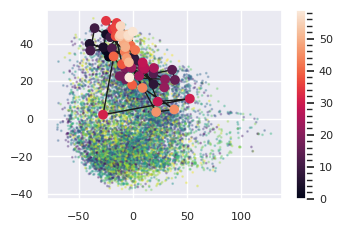

In [63]:
colors = np.tile(range(N_TIME_BINS), len(df))[shuffled_subsamp]
plt.plot(*embedding.T, color="k", lw=1)
plt.scatter(*embedding.T, c=range(N_TIME_BINS), zorder=2)
plt.colorbar()

plt.scatter(*all_spectral_coeff.T, s=1, alpha=0.3, c= colors, cmap="viridis")

In [36]:
from djanloo_fourier import STFTransformer

transf = STFTransformer(n_time_bins=None, 
                        n_spectral_bins=None, 
                        max_frequency=3000, 
                        sampling_rate=SAMPLING_RATE)

# Makes a square STFT
transf.balance_n_coeff(traces["clean_trace"])
transf.report(traces["clean_trace"])
STFT, sc = transf.fit_transform(traces["clean_trace"])

Time bins = 122, Spectral bins = 122
min length of window is roughly 247
max number of Fourier coeffs is 123


  0%|                                                                                                                        | 0/2452 [00:00<?, ?it/s]


ValueError: Error in track 0, that has window length equal to 80